In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from math import e
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/titanic.csv")
df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1,inplace=True)
df = pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True)
df.replace({True : 1, False : 0}, inplace=True)

In [4]:
def converter(col):
    col = col.split(".")
    if len(col) > 2:
        res = "".join(col[ : -1]) + "." + col[-1]
    else:
        res = ".".join(col)
    return float(res)

df.Fare = df.Fare.apply(converter)

In [5]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.250,1,0,1
1,1,1,38.0,1,0,712.833,0,0,0
2,1,3,26.0,0,0,7.925,0,0,1
3,1,1,35.0,1,0,53.100,0,0,1
4,0,3,35.0,0,0,8.050,1,0,1


In [6]:
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [7]:
def fillAge(age):
    if pd.isna(age):
        return np.random.randint(int(df.Age.quantile(0.25)), int(df.Age.quantile(0.75)))
    return age

df.Age = df.Age.apply(fillAge)

In [8]:
X = df.drop("Survived", axis = 1)
y = df["Survived"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [10]:
X_train_copy = X_train.copy()
X_train["Pclass"] = X_train["Pclass"] / 3
X_train["Age"] = (X_train["Age"] - X_train["Age"].min()) /  (X_train["Age"].max() - X_train["Age"].min())
X_train["SibSp"] = (X_train["SibSp"] - X_train["SibSp"].min()) /  (X_train["SibSp"].max() - X_train["SibSp"].min())
X_train["Parch"] = (X_train["Parch"] - X_train["Parch"].min()) /  (X_train["Parch"].max() - X_train["Parch"].min())
X_train["Fare"] = (X_train["Fare"] - X_train["Fare"].min()) /  (X_train["Fare"].max() - X_train["Fare"].min())

In [11]:
class MyLogisticRegression:
    
    def __init__(self, rate = 0.1, iterations = 10000):
        self.__w = np.array([])
        self.__rate = rate
        self.__iterations = iterations
        self.costH = []
        
    def __cost (self, Y, h):
        return (-Y * np.log(h) - (1 - Y) * np.log(1 - h)).mean()
    
    def __sigmoid(self, z):
        return 1 / (1 + e ** -z)
    
    def coefs(self):
        return self.__w
        
    def fit(self, X, y):
        self.__w = np.zeros((len(X[0])))
        for i in range(self.__iterations):
            z = np.dot(X, self.__w)
            h = self.__sigmoid(z)
            diff = (h - y)
            g = np.dot(X.T, diff) / len(y)
            self.__w = self.__w - self.__rate * g
            
            cost = self.__cost(y, h)
            self.costH.append(cost)
            
            if i % 1000 == 0:
                print("iteration :", i)
                print(cost)
                print()
    
    def predict(self, X):
        val = np.dot(X, self.__w)
        p = self.__sigmoid(val)
        
        p[ p >= 0.5 ] = 1
        p[ p < 0.5] = 0
        
        return p
            

In [12]:
training_inputs = [[1] for i in range(len(y_train))]
for i in range(len(training_inputs)):
    training_inputs[i].extend(X_train.to_numpy()[i])

training_inputs = np.array(training_inputs)

outputs = np.array(y_train)

In [13]:
myModel = MyLogisticRegression()

In [14]:
myModel.fit(training_inputs, outputs)

iteration : 0
0.6931471805599451

iteration : 1000
0.48062776604243196

iteration : 2000
0.46600546587945935

iteration : 3000
0.4595518373726254

iteration : 4000
0.4558588970583633

iteration : 5000
0.45355772759172197

iteration : 6000
0.45207219508539936

iteration : 7000
0.45109249243973715

iteration : 8000
0.45043549866773014

iteration : 9000
0.4499884177866459



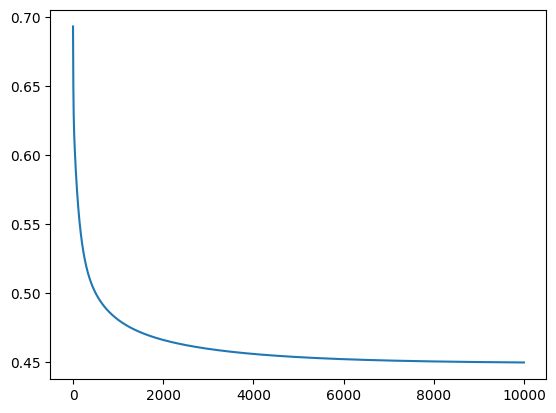

In [15]:
plt.plot(myModel.costH)

In [16]:
X_test["Pclass"] = X_test["Pclass"] / 3
X_test["Age"] = (X_test["Age"] - X_train_copy["Age"].min()) /  (X_train_copy["Age"].max() - X_train_copy["Age"].min())
X_test["SibSp"] = (X_test["SibSp"] - X_train_copy["SibSp"].min()) /  (X_train_copy["SibSp"].max() - X_train_copy["SibSp"].min())
X_test["Parch"] = (X_test["Parch"] - X_train_copy["Parch"].min()) /  (X_train_copy["Parch"].max() - X_train_copy["Parch"].min())
X_test["Fare"] = (X_test["Fare"] - X_train_copy["Fare"].min()) /  (X_train_copy["Fare"].max() - X_train_copy["Fare"].min())

In [17]:
test_inputs = [[1] for i in range(len(y_test))]
for i in range(len(test_inputs)):
    test_inputs[i].extend(X_test.to_numpy()[i])

test_inputs = np.array(test_inputs)


In [18]:
my_predictions = myModel.predict(test_inputs)

In [19]:
y_test = list(y_test)
right = 0
for i in range(len(y_test)):
    # print(f"Prediction : {int(my_predictions[i])}, expected : {y_test[i]}")
    if int(my_predictions[i]) == y_test[i]:
        right += 1
    
my_acc = right / len(y_test)

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)

In [21]:
right = 0
for i in range(len(y_test)):
    # print(f"Prediction : {int(model_predictions[i])}, expected : {y_test[i]}")
    if int(model_predictions[i]) == y_test[i]:
        right += 1
model_acc = right / len(y_test)

In [22]:
print(f"My accuracy is : {int(my_acc * 100)}%, Model accuracy is {int(model_acc * 100)}%")

My accuracy is : 82%, Model accuracy is 82%
